In [68]:
import torch
import torch.nn as nn
from torch.amp import GradScaler
from torch import autocast
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import sys
import csv
import os
import gc

import torch.profiler

np.random.seed(1234)

In [69]:
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.current_device())  # Should return an integer (GPU index)
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # GPU name

True
0
NVIDIA GeForce RTX 2060


In [77]:
# CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f"Using device: {device}")

torch.backends.cudnn.benchmark = True

Using device: cuda


In [71]:
class DNN(nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        modules = []
        for i in range(len(layers) - 2):  # Exclude last layer for activation
            modules.append(nn.Linear(layers[i], layers[i+1]))
            modules.append(nn.Tanh())
        modules.append(nn.Linear(layers[-2], layers[-1]))  # Last layer (no activation)
        self.network = nn.Sequential(*modules)

        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.network(x)

In [ ]:
w_pde = 1.0
w_bc = 1.0

In [91]:
class PINN():
    def __init__(self, layers, x, q):

        self.x = x
        self.q = q
        print(type(self.x), x.dtype)

        # DNN
        self.dnn = DNN(layers).to(device)

        # Optimizer
        self.optimizer_lbfgs = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=0.1,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-7,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )

        self.optimizer_adam = torch.optim.Adam(self.dnn.parameters(), lr=0.01)
        self.iter = 0
        self.scaler = GradScaler(device)

    def model_value(self, x):
        out = self.dnn(x)
        u = out[:,0].view(-1, 1)
        m = out[:,1].view(-1, 1)
        return u, m
    
    def loss_func(self, x):
        u, m = self.model_value(x)
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        u_2x = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]

        m_x = torch.autograd.grad(m, x, torch.ones_like(m), create_graph=True)[0]
        m_2x = torch.autograd.grad(m_x, x, torch.ones_like(m_x), create_graph=True)[0]

        # BC
        bc_loss = torch.pow(u[0], 2) + torch.pow(u_x[0], 2)
        bc_loss += torch.pow(m[-1], 2) + torch.pow(m_x[-1], 2)

        # PDE
        pde_loss = torch.mean(torch.pow(m_2x + self.q, 2))
        pde_loss += torch.mean(torch.pow(u_2x + m, 2))

        return pde_loss, bc_loss


    def lbfgs_func(self):
        pde_loss, bc_loss = self.loss_func(self.x)
        loss = w_pde*pde_loss + w_bc*bc_loss

        self.optimizer_lbfgs.zero_grad()
        loss.backward()

        if self.iter % 100 == 0:
            print(f"Iter: {self.iter}, PDE loss: {'{:e}'.format(pde_loss.item())}, BC loss: {'{:e}'.format(bc_loss.item())}")
        self.iter += 1
        return loss
    
    def train(self, epochs=1000):
        self.dnn.train()
        for epoch in range(epochs):
            pde_loss, bc_loss = self.loss_func(self.x)
            loss = w_pde*pde_loss + w_bc*bc_loss

            self.optimizer_adam.zero_grad()
            loss.backward()
            self.optimizer_adam.step()

            if epoch % 100 == 0:
                print(f"Epoch: {epoch}, PDE loss: {'{:e}'.format(pde_loss.item())}, BC loss: {'{:e}'.format(bc_loss.item())}")

        self.optimizer_lbfgs.step(self.lbfgs_func)

    def predict(self, X, q0, L, EI):
        x = torch.tensor(X, requires_grad=True).float().to(device)

        self.dnn.eval()
        u_c, m_c = self.model_value(x)
        u_c = u_c.detach().cpu().numpy()
        m_c = m_c.detach().cpu().numpy()
        # u = (q0 * L**4 / EI) * u_c
        return u_c, m_c

# Parameters

In [122]:
EI = 2000.0
L = 3.0
Q = -200.0

In [123]:
qx1 = lambda x: np.full_like(x, Q) # Constant
qx2 = lambda x: Q*2/L**2 * x # Increasing
qx3 = lambda x: Q*2/L**2 * (L - x) # Decrasing

# Exact solutions

In [124]:
x = np.random.uniform(0, L, 1000)
x = np.append(x, [0, L])
x = np.sort(x).reshape(-1, 1)
x_hat = x / L

q = qx1(x)
q0 = np.max(np.abs(q))
print(q0)
q_hat = q/q0

x_t = torch.tensor(x_hat, device=device, requires_grad=True).float()
q_t = torch.tensor(q_hat, device=device).float()
layers = [1, 20, 20, 20, 2]

200.0


In [125]:
model = PINN(layers, x_t, q_t)
print(model.dnn)
next(model.dnn.parameters()).is_cuda

<class 'torch.Tensor'> torch.float32
DNN(
  (network): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=2, bias=True)
  )
)


True

In [126]:
%%time

model.train(2000)

Epoch: 0, PDE loss: 9.277571e-01, BC loss: 2.992558e-01
Epoch: 100, PDE loss: 7.201898e-03, BC loss: 2.195289e-05
Epoch: 200, PDE loss: 1.778903e-04, BC loss: 2.657852e-07
Epoch: 300, PDE loss: 1.279811e-04, BC loss: 5.687170e-06
Epoch: 400, PDE loss: 9.465312e-05, BC loss: 2.473472e-08
Epoch: 500, PDE loss: 3.841417e-04, BC loss: 2.982506e-04
Epoch: 600, PDE loss: 9.380859e-05, BC loss: 1.942329e-08
Epoch: 700, PDE loss: 7.317070e-05, BC loss: 7.549500e-09
Epoch: 800, PDE loss: 6.124560e-05, BC loss: 2.257467e-09
Epoch: 900, PDE loss: 1.208811e-04, BC loss: 8.162476e-06
Epoch: 1000, PDE loss: 8.471037e-05, BC loss: 7.944389e-09
Epoch: 1100, PDE loss: 7.281401e-05, BC loss: 3.791237e-10
Epoch: 1200, PDE loss: 6.617356e-05, BC loss: 1.288825e-09
Epoch: 1300, PDE loss: 6.110189e-05, BC loss: 1.856004e-09
Epoch: 1400, PDE loss: 5.671942e-05, BC loss: 1.976326e-09
Epoch: 1500, PDE loss: 1.850186e-03, BC loss: 3.447492e-03
Epoch: 1600, PDE loss: 8.409817e-05, BC loss: 3.053094e-08
Epoch: 17

In [59]:
del model
gc.collect()
torch.cuda.empty_cache()

In [127]:
def exact_solution(x):
    y = Q/(24*EI)*(x**4 - 4*L*x**3 + 6*L**2*x**2)
    return y

(100, 1) (100, 1)
L2 Error: 4.533716077163662e-05


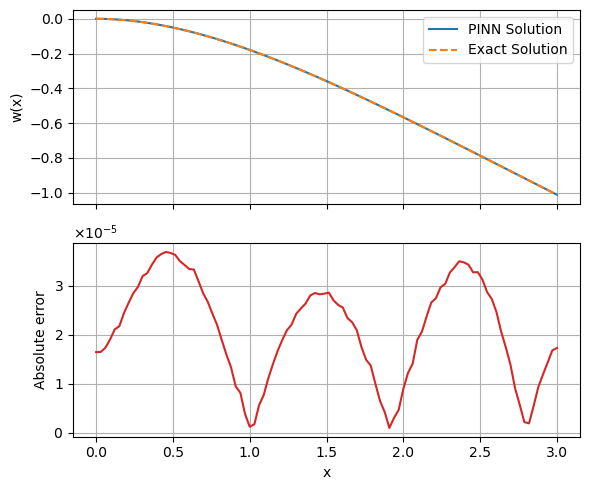

In [129]:
x = np.linspace(0,L,100).reshape(-1, 1)

# Predict
u, m = model.predict(x/L, q0, L, EI)
u_pred = (L**4 * q0 / EI) * u
m_pred = (L**2 * q0) * m


# Exact
u_exact = exact_solution(x)

u_error = np.linalg.norm(u_pred - u_exact) / np.linalg.norm(u_exact,2)
print(u_exact.shape, u_pred.shape)
abs_error = np.abs(u_pred - u_exact)
print(f"L2 Error: {u_error}")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5), sharex=True)

ax1.plot(x, u_pred, label="PINN Solution")
ax1.plot(x, u_exact, label="Exact Solution", linestyle="dashed")
ax1.set(ylabel='w(x)')
ax1.legend()
ax1.grid()

ax2.plot(x, abs_error, 'tab:red')
ax2.set(xlabel='x', ylabel='Absolute error')
ax2.grid()

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))  # Defines when to switch to scientific notation

ax2.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

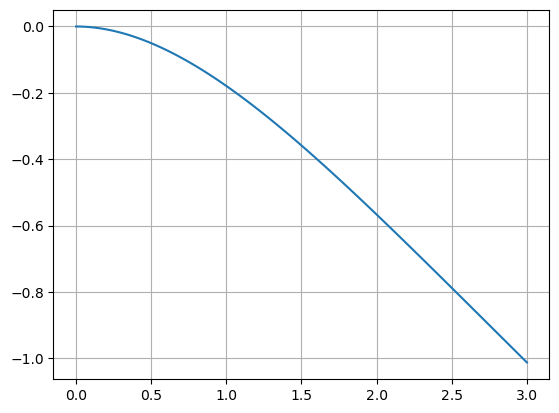

In [115]:
u_exact = exact_solution(x)
plt.plot(x,u_exact)
plt.grid()